# Deconvolution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import load_neo, write_neo, AnalogSignal2ImageSequence, ImageSequence2AnalogSignal
import neo
import quantities as pq
import scipy.signal as signal
from scipy.signal import deconvolve, convolve, iirnotch
from scipy.stats import mode, gaussian_kde
from scipy.spatial import *

## Loading .nix file

In [2]:
# load the neo block (output of the stage_01)
block = load_neo('LENS_170110_mouse2_t1.nix')

## Converting into images

Text(0.5, 0, 'time/time step')

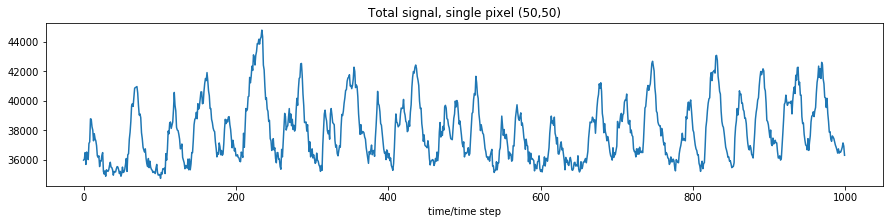

In [3]:
# trasformation in the "ImageSequence" class
blockIm = AnalogSignal2ImageSequence(block)
# converts the imagesequence class in a 3D Numpy array
imgseq = blockIm.segments[0].imagesequences[-1]
imgseq_array = imgseq.as_array()
dim_t, dim_x, dim_y = imgseq_array.shape

# plot of the total signal vs sampling time, pixel (50,50)
plt.figure(figsize=(15,3))
plt.plot(imgseq_array[:,50,50])
plt.title('Total signal, single pixel (50,50)')
plt.xlabel('time/time step')

Time and frequency axes

In [4]:
# sampling time interval (seconds)
t_step = block.segments[0].analogsignals[0].sampling_period.magnitude.tolist()
# total sampling time (seconds)
t_end = 40
# time sampling array, includes 0
time = np.arange(t_step,t_end+t_step,t_step)
# sample frequency array
freq = np.fft.rfftfreq(time.size, d=t_step)

# Response function (kernel)

In [5]:
def lognormal(t,mu,s):
    t_step = t[-1]/t.size
    log = 1/(t/t_step*np.sqrt(2*np.pi)*s)*np.exp(-(np.log(t/t_step)-mu)**2/(2*s**2))
    return log / (np.sum(log)*t_step)

def combexp(t,tr,td):
    t_step = t[-1]/t.size
    func = (1-np.exp(-t/tr))*(np.exp(-t/td))
    return func / (np.sum(func)*t_step)

def alpha(t,tau,n):
    t_step = t[-1]/t.size
    func = (t/tau)**n * np.exp(-t/tau)
    return func / (np.sum(func)*t_step)

# Mean region

Text(0.5, 0, 'time (s)')

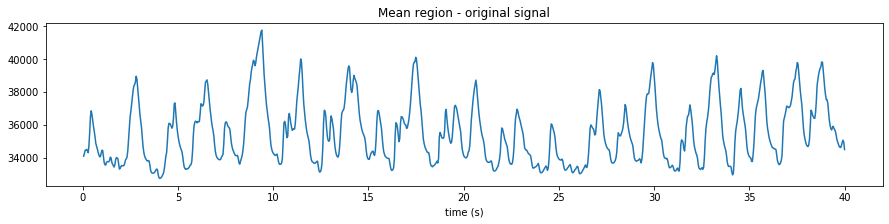

In [6]:
x_start, x_end = (50, 70) #50,70
y_start, y_end = (40, 60) #40,60
avg_region = np.zeros(dim_t)
for t in range(dim_t):
    m = 0
    for i in range(x_start, x_end):
        for j in range(y_start, y_end):
            m += imgseq_array[t][i][j]
    avg_region[t] = m / ((x_end-x_start)*(y_end-y_start))

plt.figure(figsize=(15,3))
plt.title('Mean region - original signal')
plt.plot(time,avg_region)
plt.xlabel('time (s)')

## Initial + final ramp

Text(0.5, 0, 'time (s)')

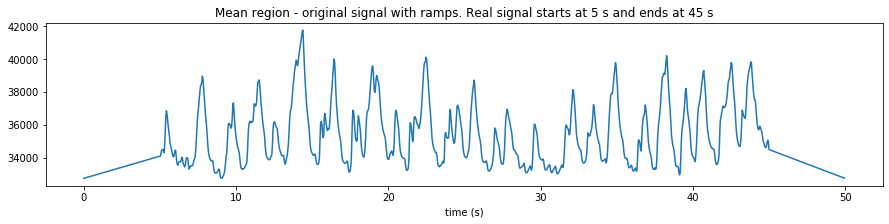

In [7]:
ymin = min(avg_region) # start and end point
ylast = avg_region[-1]
y0 = avg_region[0]
ramp_length = 5 #seconds

t_first = np.arange(0,5,0.04)
t_last = np.arange(45,50,0.04)
m_first = (y0 - ymin)/ramp_length
initial_ramp = m_first*t_first + ymin
m_last = (ymin - ylast)/ramp_length
final_ramp = m_last*(t_last-t_last[0]) + ylast

time_ramp = np.append(np.append(t_first, time+5), t_last)
y_ramp = np.append(np.append(initial_ramp, avg_region), final_ramp)

plt.figure(figsize=(15,3))
plt.plot(time_ramp, y_ramp)
plt.title('Mean region - original signal with ramps. Real signal starts at 5 s and ends at 45 s')
plt.xlabel('time (s)')

## Lognormal $\quad \frac{1}{t}\frac{1}{\sqrt{2\pi}\sigma} exp(-\frac{(ln (t) - \mu)^2}{2\sigma^2})$

In [8]:
# defining the guessed lognormal kernel - max in ~157.6 ms (i=394)
mean = 2.2 #2.2
sigma = 0.91 #0.91
# lognormal function array
log = lognormal(time,mean,sigma)
# calculating the Fourier transform
log_ft = np.fft.rfft(log)

# Quality functions

## Constraint 1 : minimum distace from the guessed lognormal

In [9]:
# [start,end,step] in ms
tau_0 = np.array([[0.001, 1.0, 0.01]])
tau_1 = np.array([[0.001, 0.5, 0.01]])
tau_2 = np.array([[0.0001, 0.16, 0.001]])
tau = np.concatenate((tau_0,tau_1,tau_2)) # matrix with all the [start,end,step], for better browsing in the cycle
# distance (scoring) arrays for each n
distances_0 = np.zeros([int(tau[0][1]/tau[0][2])+1])
distances_1 = np.zeros([int(tau[1][1]/tau[1][2])+1])
distances_2 = np.zeros([int(tau[2][1]/tau[2][2])+1]) #cannot concatenate arrays with different size...?
for i in range(tau.shape[1]): # cycle on n
    for j in np.arange(tau[i][0], tau[i][1]+tau[i][2], tau[i][2]): # cycle on tau
        if i==0:
            distances_0[int(j/tau[i][2])] = distance.euclidean(alpha(time, j, i), log)
        elif i==1:
            distances_1[int(j/tau[i][2])] = distance.euclidean(alpha(time, j, i), log)
        elif i==2:
            distances_2[int(j/tau[i][2])] = distance.euclidean(alpha(time, j, i), log)
            
print("Best value for n = 0 : tau =",tau[0][0]+distances_0.argmin()*tau[0][2])
print("Best value for n = 1 : tau =",tau[1][0]+distances_1.argmin()*tau[1][2])
print("Best value for n = 2 : tau =",tau[2][0]+distances_2.argmin()*tau[2][2])

Best value for n = 0 : tau = 0.551
Best value for n = 1 : tau = 0.201
Best value for n = 2 : tau = 0.1271


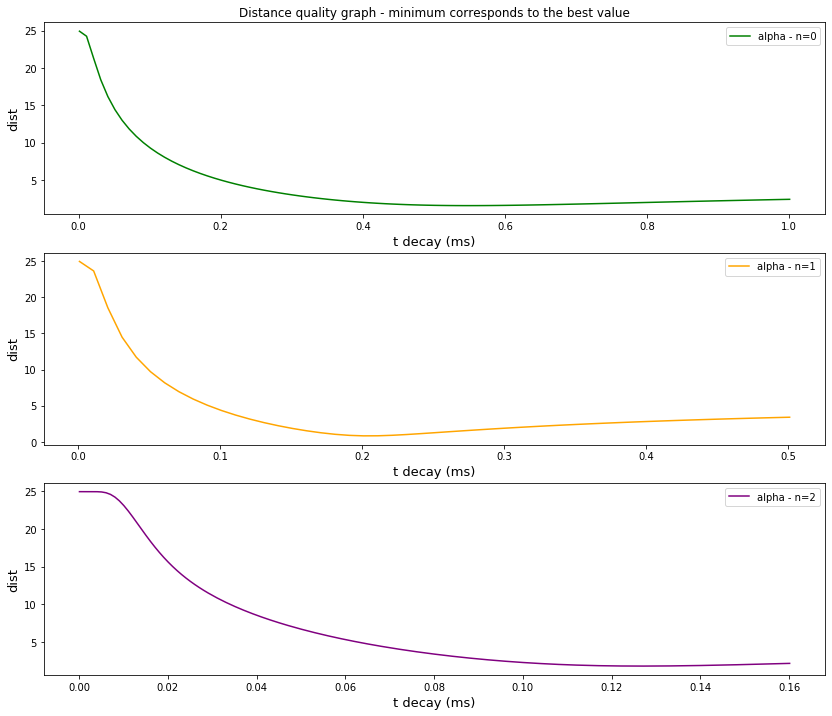

In [10]:
plt.figure(figsize = (14,12))
for i in range(tau.shape[1]):
    plt.subplot(3,1,1+i)
    if i==0:
        plt.title('Distance quality graph - minimum corresponds to the best value')
        plt.plot(np.arange(tau[i][0], tau[i][1]+tau[i][2], tau[i][2]), distances_0, color='green', label='alpha - n=0')
        plt.xlabel('t decay (ms)', fontsize=13)
        plt.ylabel('dist', fontsize=13)
        plt.legend()
    elif i==1:
        plt.plot(np.arange(tau[i][0], tau[i][1]+tau[i][2], tau[i][2]), distances_1, color='orange', label='alpha - n=1')
        plt.xlabel('t decay (ms)', fontsize=13)
        plt.ylabel('dist', fontsize=13)
        plt.legend()
    elif i==2: 
        plt.plot(np.arange(tau[i][0], tau[i][1]+tau[i][2], tau[i][2]), distances_2, color='purple', label='alpha - n=2')
        plt.xlabel('t decay (ms)', fontsize=13)
        plt.ylabel('dist', fontsize=13)
        plt.legend()
        
plt.show()
#plt.savefig(fname='quality_dist_01.png')

## Constraint 2 : mean - mode > 0

In [11]:
sp_def = 0.1
delay = 125
# [start,end,step] in ms
tau_0 = np.array([[0.001, 0.7, 0.01]])
tau_1 = np.array([[0.001, 0.4, 0.01]])
tau_2 = np.array([[0.0001, 0.13, 0.01]])
tau = np.concatenate((tau_0,tau_1,tau_2)) # matrix with all the [start,end,step], for better browsing in the cycle
mm_0 = np.zeros(int(round((tau[0][1]-tau[0][0])/tau[0][2]))+1)
mm_1 = np.zeros(int(round((tau[1][1]-tau[1][0])/tau[1][2]))+1)
mm_2 = np.zeros(int(round((tau[2][1]-tau[2][0])/tau[2][2]))+1)

for i in range(tau.shape[1]): # cycle on n
    for j in np.arange(tau[i][0], tau[i][1]+tau[i][2], tau[i][2]): # cycle on tau
        act = deconvolve(y_ramp, alpha(time, j, i)[:50])[0]
        act_nodiv = act[delay:act.size-delay]
        kde = gaussian_kde(act_nodiv, bw_method='silverman')
        kde_mod = act_nodiv.min() + sp_def*kde(np.arange(act_nodiv.min(), act_nodiv.max(), sp_def)).argmax()
        med = np.mean(act)
        #print(med,kde_mod)
        if i==0:
            mm_0[int(round((j-tau[i][0])/tau[i][2]))] = (med-kde_mod)
        
        elif i==1:
            mm_1[int(round((j-tau[i][0])/tau[i][2]))] = (med-kde_mod)
        
        elif i==2:
            mm_2[int(round((j-tau[i][0])/tau[i][2]))] = (med-kde_mod)
          
print("Best value for n = 0 : tau =",tau[0][0]+mm_0.argmax()*tau[0][2])
print("Best value for n = 1 : tau =",tau[1][0]+mm_1.argmax()*tau[1][2])
print("Best value for n = 2 : tau =",tau[2][0]+mm_2.argmax()*tau[2][2])

Best value for n = 0 : tau = 0.7010000000000001
Best value for n = 1 : tau = 0.051000000000000004
Best value for n = 2 : tau = 0.1301


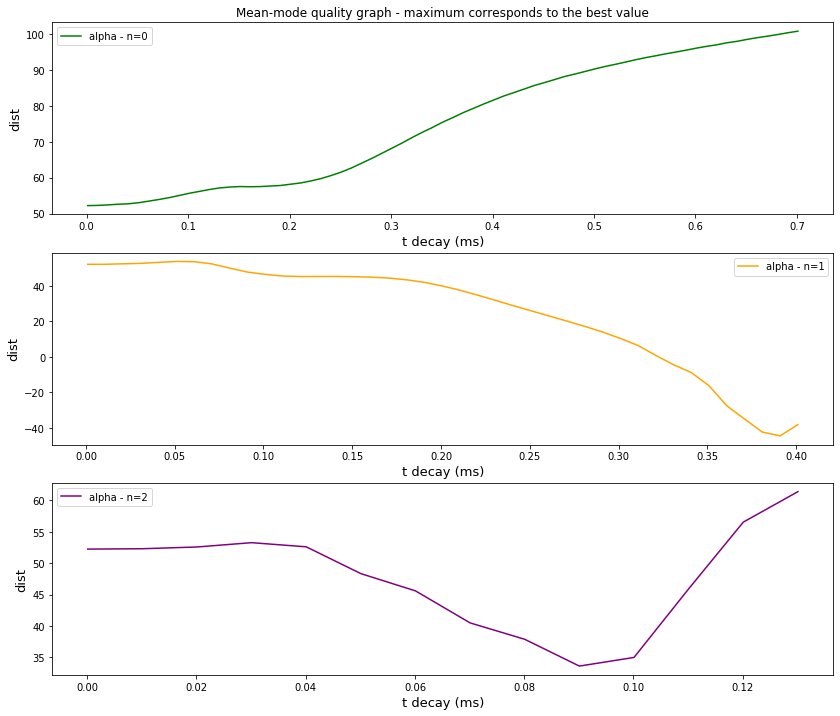

In [12]:
plt.figure(figsize = (14,12))
for i in range(tau.shape[1]):
    plt.subplot(3,1,1+i)
    if i==0:
        plt.title('Mean-mode quality graph - maximum corresponds to the best value')
        plt.plot(np.arange(tau[i][0], tau[i][1]+tau[i][2], tau[i][2]), mm_0, color='green', label='alpha - n=0')
        plt.xlabel('t decay (ms)', fontsize=13)
        plt.ylabel('dist', fontsize=13)
        plt.legend()
    elif i==1:
        plt.plot(np.arange(tau[i][0], tau[i][1]+tau[i][2], tau[i][2]), mm_1, color='orange', label='alpha - n=1')
        plt.xlabel('t decay (ms)', fontsize=13)
        plt.ylabel('dist', fontsize=13)
        plt.legend()
    elif i==2: 
        plt.plot(np.arange(tau[i][0], tau[i][1]+tau[i][2], tau[i][2]), mm_2, color='purple', label='alpha - n=2')
        plt.xlabel('t decay (ms)', fontsize=13)
        plt.ylabel('dist', fontsize=13)
        plt.legend()
        
plt.show()
#plt.savefig(fname='quality_mm.png')

## Best reasonable values overall ?

In [13]:
print("Best value for n = 0 : tau =",tau[0][0]+mm_0[:int((0.18-tau[0][0])/tau[0][2])].argmax()*tau[0][2])
print("Best value for n = 1 : tau =",0.13+mm_1[int((0.13-tau[1][0])/tau[1][2]):int((0.25-tau[1][0])/tau[1][2])].argmax()*tau[1][2])
print("Best value for n = 2 : tau =",tau[2][0]+mm_2[:int((0.06-tau[2][0])/tau[2][2])].argmax()*tau[2][2])

Best value for n = 0 : tau = 0.151
Best value for n = 1 : tau = 0.15
Best value for n = 2 : tau = 0.0301


## $\alpha$- function $\quad(\frac{t}{\tau})^n e^{-t/\tau} $

In [14]:
alpha0 = alpha(time,0.55,0) #0.55
alpha1 = alpha(time,0.2,1) #0.2
alpha2 = alpha(time,0.127,2) #0.127
# calculating the Fourier transform
alpha0_ft = np.fft.rfft(alpha0)
alpha1_ft = np.fft.rfft(alpha1)
alpha2_ft = np.fft.rfft(alpha2)

#FT Normalization
freq_step = 0.025
integ_ft = np.sum(log_ft)*freq_step
integ0_ft = np.sum(alpha0_ft)*freq_step
integ1_ft = np.sum(alpha1_ft)*freq_step
integ2_ft = np.sum(alpha2_ft)*freq_step
log_ft_norm = log_ft / integ_ft
alpha0_ft_norm = alpha0_ft / integ0_ft
alpha1_ft_norm = alpha1_ft / integ1_ft
alpha2_ft_norm = alpha2_ft / integ2_ft

## Comparisons

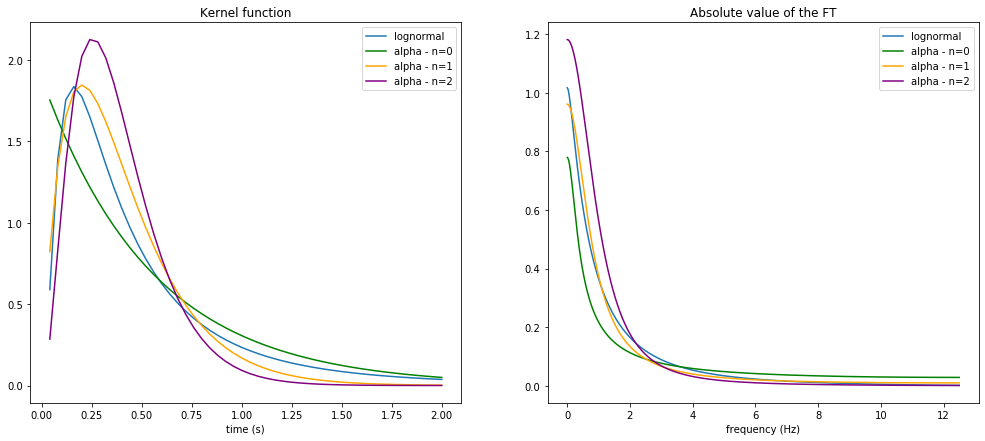

In [15]:
plt.figure(1,figsize=(17,7))
plt.subplot(121)
#plot of the kernel function
plt.plot(time[:50],log[:50], label='lognormal')
plt.plot(time[:50],alpha0[:50], label='alpha - n=0', color='green')
plt.plot(time[:50],alpha1[:50], label='alpha - n=1', color='orange')
plt.plot(time[:50],alpha2[:50], label='alpha - n=2', color='purple')
plt.xlabel('time (s)')
plt.title('Kernel function')
plt.legend()
plt.subplot(122)
# plot of the absolute value of the FT
plt.plot(freq, np.abs(log_ft_norm), label='lognormal')
plt.plot(freq, np.abs(alpha0_ft_norm), label='alpha - n=0', color='green')
plt.plot(freq, np.abs(alpha1_ft_norm), label='alpha - n=1', color='orange')
plt.plot(freq, np.abs(alpha2_ft_norm), label='alpha - n=2', color='purple')
plt.xlabel('frequency (Hz)')
plt.title('Absolute value of the FT')
plt.legend()

# Deconvolution

In [16]:
#ALPHA
mean_activity_1 = deconvolve(avg_region,alpha1[:50])
ramp_activity_0 = deconvolve(y_ramp, alpha0[:50])
ramp_activity_1 = deconvolve(y_ramp, alpha1[:50])
ramp_activity_2 = deconvolve(y_ramp, alpha2[:50])

## Binning and Mode

In [17]:
# kernel estimation on data
kde = gaussian_kde(ramp_activity_1[0], bw_method='silverman')
sp_res = 1 # fixing the resolution
delay = 125
kde_act = ramp_activity_1[0][delay:-delay]
ker_pdf = kde(np.arange(kde_act.min(), kde_act.max(), sp_res))
kde_mod = kde_act.min() + sp_res*ker_pdf.argmax()
print("mode =",kde_mod)

mode = 1381.2352682339306


<function matplotlib.pyplot.show(*args, **kw)>

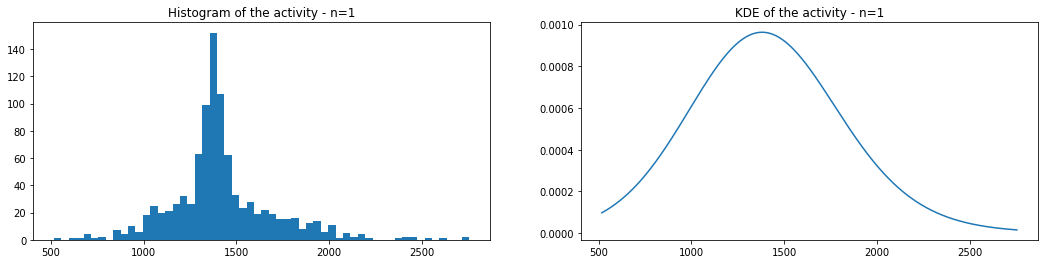

In [18]:
plt.figure(figsize=(18,4))
plt.subplot(121)
plt.title("Histogram of the activity - n=1")
plt.hist(kde_act, bins='auto')
#plt.plot(np.arange(kde_act.min(),kde_act.max(),sp_res),ker_pdf)
plt.subplot(122)
plt.title("KDE of the activity - n=1")
plt.plot(np.arange(kde_act.min(),kde_act.max(),sp_res),ker_pdf)
plt.show

## Deconvolved activity - best values according to the constraint 1

Text(0.5, 0, 'time (s)')

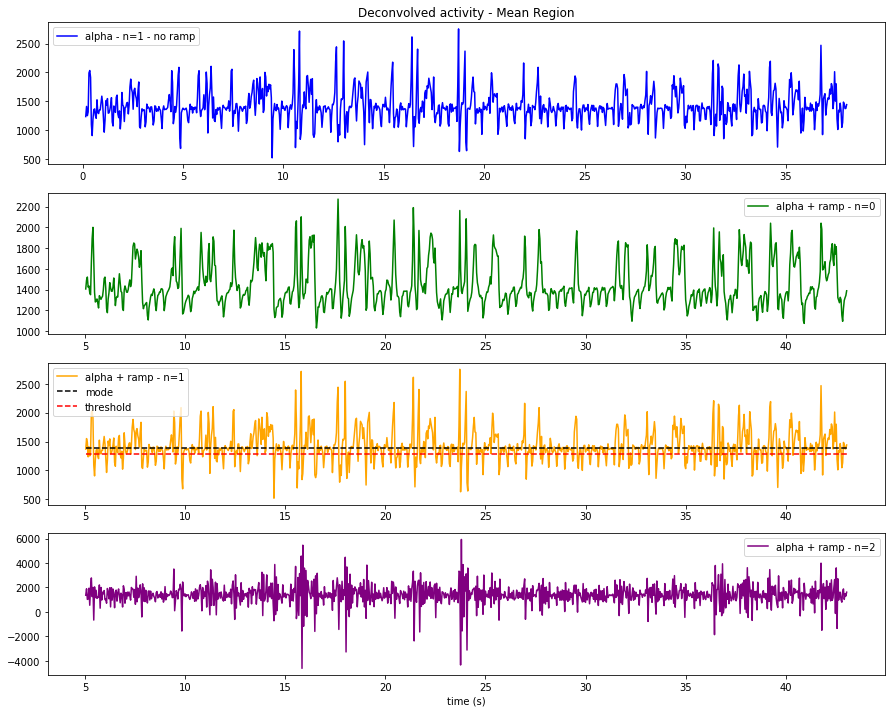

In [19]:
plt.figure(figsize=(15,12))
delay = 125 # 5s
thre = 1280 # a occhio...
plt.subplot(411)
plt.title('Deconvolved activity - Mean Region')
plt.plot(time[3:mean_activity_1[0].size], mean_activity_1[0][3:], label='alpha - n=1 - no ramp', color='blue')
plt.legend()
plt.subplot(412)
plt.plot(time_ramp[delay:ramp_activity_0[0].size-delay], ramp_activity_0[0][delay:ramp_activity_0[0].size-delay], label='alpha + ramp - n=0', color='green')
plt.legend()
plt.subplot(413)
plt.plot(time_ramp[delay:ramp_activity_1[0].size-delay], ramp_activity_1[0][delay:ramp_activity_1[0].size-delay], label='alpha + ramp - n=1', color='orange')
plt.plot(time_ramp[delay:ramp_activity_1[0].size-delay], [kde_mod]*(ramp_activity_1[0].size-2*delay), '--', color = 'black', label="mode")
plt.plot(time_ramp[delay:ramp_activity_1[0].size-delay], [thre]*(ramp_activity_1[0].size-2*delay), '--', color = 'red', label="threshold")
plt.legend()
plt.subplot(414)
plt.plot(time_ramp[delay:ramp_activity_2[0].size-delay], ramp_activity_2[0][delay:ramp_activity_2[0].size-delay], label='alpha + ramp - n=2', color='purple')
plt.legend()
plt.xlabel('time (s)')
#plt.savefig(fname='deconvolved-mean.png', dpi=300)

## Deconvolved activity - best values according to the constraint 2

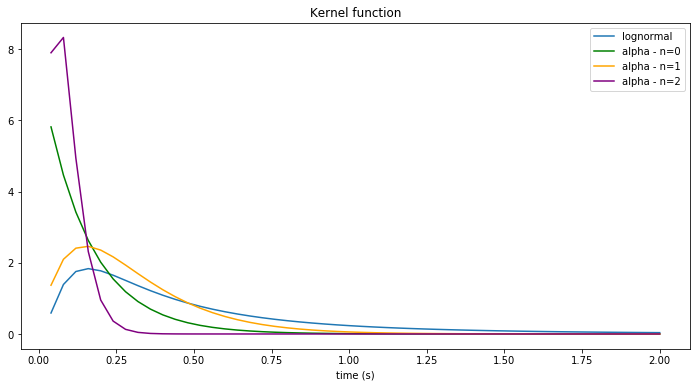

In [20]:
alphastar0 = alpha(time,0.151,0) #0.55
alphastar1 = alpha(time,0.15,1) #0.2
alphastar2 = alpha(time,0.03,2) #0.127
plt.figure(1,figsize=(12,6))
#plot of the kernel function
plt.plot(time[:50],log[:50], label='lognormal')
plt.plot(time[:50],alphastar0[:50], label='alpha - n=0', color='green')
plt.plot(time[:50],alphastar1[:50], label='alpha - n=1', color='orange')
plt.plot(time[:50],alphastar2[:50], label='alpha - n=2', color='purple')
plt.xlabel('time (s)')
plt.title('Kernel function')
plt.legend()

Text(0.5, 0, 'time (s)')

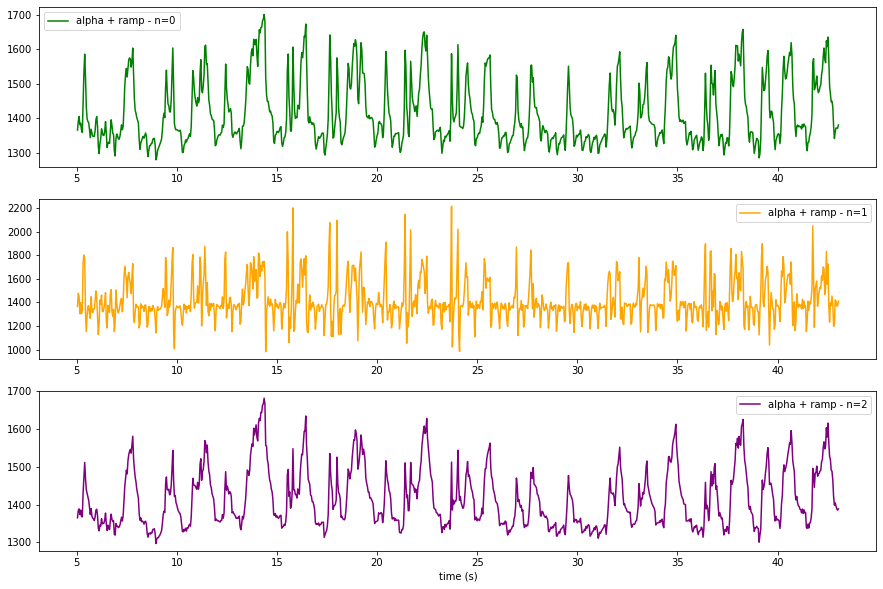

In [21]:
#ALPHA
ramp_activity_star0 = deconvolve(y_ramp, alphastar0[:50])
ramp_activity_star1 = deconvolve(y_ramp, alphastar1[:50])
ramp_activity_star2 = deconvolve(y_ramp, alphastar2[:50])
plt.figure(figsize=(15,10))
delay = 125 # 5s
thre = 1280 # a occhio...
plt.subplot(311)
plt.plot(time_ramp[delay:ramp_activity_star0[0].size-delay], ramp_activity_star0[0][delay:ramp_activity_star0[0].size-delay], label='alpha + ramp - n=0', color='green')
plt.legend()
plt.subplot(312)
plt.plot(time_ramp[delay:ramp_activity_star1[0].size-delay], ramp_activity_star1[0][delay:ramp_activity_star1[0].size-delay], label='alpha + ramp - n=1', color='orange')
plt.legend()
plt.subplot(313)
plt.plot(time_ramp[delay:ramp_activity_star2[0].size-delay], ramp_activity_star2[0][delay:ramp_activity_star2[0].size-delay], label='alpha + ramp - n=2', color='purple')
plt.legend()
plt.xlabel('time (s)')

## ISI

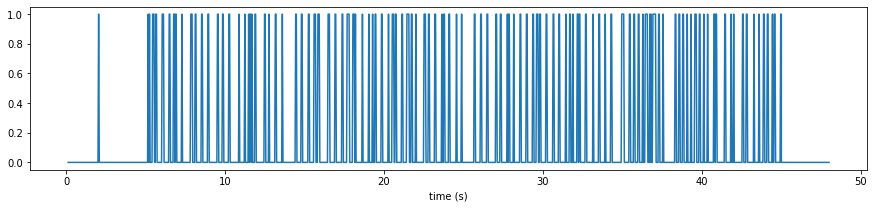

In [22]:
under = 1-np.heaviside(ramp_activity_1[0]-thre, 0)
plt.figure(figsize=(15,3))
plt.plot(time_ramp[3:ramp_activity_1[0].size], under[3:])
plt.xlabel("time (s)")
plt.show()

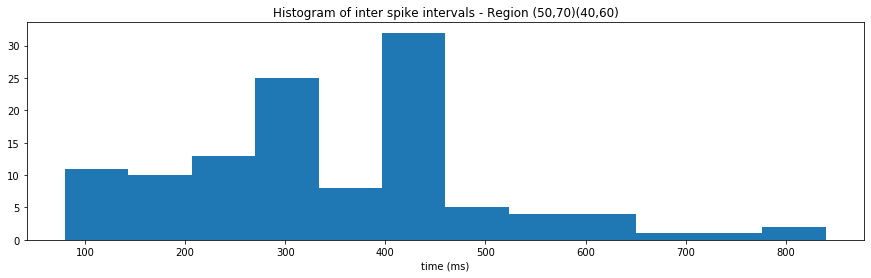

In [23]:
nonzero = np.heaviside(under-0.5, 0)
isi = np.diff(np.where(np.diff(nonzero) == 1))*40 #sampling rate = 40ms
#isi[0]

plt.figure(figsize=(15,4))
plt.hist(isi[0][2:], bins='auto')
plt.title("Histogram of inter spike intervals - Region (50,70)(40,60)")
plt.xlabel("time (ms)")
#plt.savefig(fname='ISI-.png')
plt.show()